## NER dataset visualization

### Install and import libraries

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from umap import UMAP
from tqdm.auto import tqdm

/home/daniel/projects/git/organizations/data-science-adventure/huggingface-tutorial/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Configuration and device setup


In [ ]:
# Prioritizing efficiency with float16 and GPU by default
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# Using torch.float16 for significant speed and memory efficiency on modern NVIDIA GPUs
DTYPE = torch.float16 if DEVICE == "cuda" else torch.float32

# Model and Dataset
EMBEDDING_MODEL_NAME = "all-MiniLM-L6-v2"
DATASET_NAME = "conll2003"
# Limit the dataset size to a fixed number for fast, reproducible demonstration
MAX_SAMPLES = 2000 
# Set a seed for UMAP reproducibility
SEED = 42

print(f"Using device: {DEVICE} with dtype: {DTYPE}")
print(f"Processing the first {MAX_SAMPLES} sentences from the '{DATASET_NAME}' dataset for speed.")


Using device: cpu with dtype: torch.float32
Processing the first 2000 sentences from the 'conll2003' dataset for speed.


### Loading conll2003 dataset

In [ ]:
print("\nLoading and processing dataset...")
dataset = load_dataset(DATASET_NAME, split='train')
print(dataset.features["ner_tags"])
dataset[1]

Using the latest cached version of the dataset since conll2003 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'conll2003' at /home/daniel/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98 (last modified on Thu Aug 28 09:48:06 2025).



Loading and processing dataset...
List(ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']))


{'id': '1',
 'tokens': ['Peter', 'Blackburn'],
 'pos_tags': [22, 22],
 'chunk_tags': [11, 12],
 'ner_tags': [1, 2]}

### Entity extraction

Extracting the entities from the dataset

In [ ]:
def extract_entities(dataset_split, num_samples):
    """
    Iterates through the dataset and extracts full named entity strings and their labels 
    by stitching together consecutive I- (Inside) tokens.
    """
    all_entities = []
    # Get the feature names for easy mapping (e.g., 0 -> 'O', 1 -> 'B-PER', etc.)
    ner_tag_names = dataset_split.features["ner_tags"].feature.names
    
    # Iterate over a subset of the dataset with a progress bar
    for i in tqdm(range(min(len(dataset_split), num_samples)), desc="Extracting Entities"):
        tokens = dataset_split[i]['tokens']
        ner_tags = dataset_split[i]['ner_tags']
        
        current_entity = []
        current_label_id = 0
        
        for token, tag_id in zip(tokens, ner_tags):
            tag_name = ner_tag_names[tag_id]
            
            if tag_name.startswith('B-'):
                # 1. End the previous entity if one was being tracked
                if current_entity:
                    # Extract the simple label (e.g., 'PER' from 'B-PER')
                    all_entities.append((" ".join(current_entity), ner_tag_names[current_label_id].split('-')[1]))
                
                # 2. Start a new entity
                current_entity = [token]
                current_label_id = tag_id
            
            elif tag_name.startswith('I-'):
                # 3. Continue the current entity
                current_entity.append(token)
            
            elif tag_name == 'O':
                # 4. Outside a named entity, end previous entity
                if current_entity:
                    all_entities.append((" ".join(current_entity), ner_tag_names[current_label_id].split('-')[1]))
                current_entity = []
                current_label_id = 0
                
        # 5. Handle the last entity in the sentence
        if current_entity:
            all_entities.append((" ".join(current_entity), ner_tag_names[current_label_id].split('-')[1]))
            
    # Final cleanup and filtering for actual NER types
    return [
        (text, label) 
        for text, label in all_entities 
        if text and label in ['PER', 'ORG', 'LOC', 'MISC'] # Only include the 4 main NER categories
    ]


entity_data = extract_entities(dataset, MAX_SAMPLES)
entity_texts = [item[0] for item in entity_data]
entity_labels = [item[1] for item in entity_data]

print(f"Total entities extracted: {len(entity_texts)}")
entity_data

Extracting Entities: 100%|██████████| 2000/2000 [00:00<00:00, 5132.87it/s] 

Total entities extracted: 3572


[('EU', 'ORG'),
 ('German', 'MISC'),
 ('British', 'MISC'),
 ('Peter Blackburn', 'PER'),
 ('BRUSSELS', 'LOC'),
 ('European Commission', 'ORG'),
 ('German', 'MISC'),
 ('British', 'MISC'),
 ('Germany', 'LOC'),
 ('European Union', 'ORG'),
 ('Werner Zwingmann', 'PER'),
 ('Britain', 'LOC'),
 ('Commission', 'ORG'),
 ('Nikolaus van der Pas', 'PER'),
 ('European Union', 'ORG'),
 ('EU', 'ORG'),
 ('Franz Fischler', 'PER'),
 ('Fischler', 'PER'),
 ('EU-wide', 'MISC'),
 ('Britain', 'LOC'),
 ('France', 'LOC'),
 ('Bovine Spongiform Encephalopathy', 'MISC'),
 ('BSE', 'MISC'),
 ('Fischler', 'PER'),
 ('EU', 'ORG'),
 ('Spanish', 'MISC'),
 ('Loyola de Palacio', 'PER'),
 ('Fischler', 'PER'),
 ('EU', 'ORG'),
 ('France', 'LOC'),
 ('Britain', 'LOC'),
 ('Fischler', 'PER'),
 ('EU', 'ORG'),
 ('BSE', 'MISC'),
 ('British', 'MISC'),
 ('German', 'MISC'),
 ('British', 'MISC'),
 ('Europe', 'LOC'),
 ('Germany', 'LOC'),
 ("Welsh National Farmers ' Union", 'ORG'),
 ('NFU', 'ORG'),
 ('John Lloyd Jones', 'PER'),
 ('BBC radi

### Generating label distribution chart bar

/tmp/ipykernel_14334/2687199288.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")



Generating label distribution bar chart...
✅ Bar chart saved to: conll2003_entity_label_distribution.png


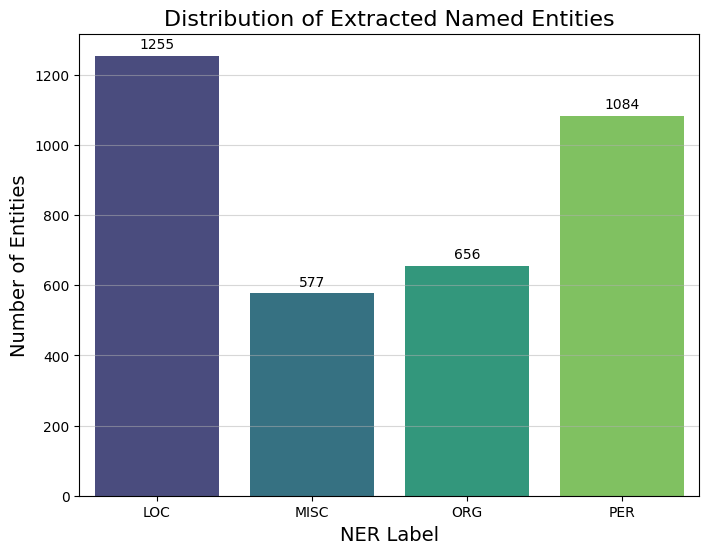

In [ ]:
print("\nGenerating label distribution bar chart...")
label_counts = pd.Series(entity_labels).value_counts().sort_index()

plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title('Distribution of Extracted Named Entities', fontsize=16)
plt.xlabel('NER Label', fontsize=14)
plt.ylabel('Number of Entities', fontsize=14)
plt.grid(axis='y', alpha=0.5)
# Annotate bars with counts
for i, count in enumerate(label_counts.values):
    plt.text(i, count + max(label_counts.values) * 0.01, str(count), ha='center', va='bottom')

BAR_CHART_FILENAME = "conll2003_entity_label_distribution.png"
plt.savefig(BAR_CHART_FILENAME, bbox_inches='tight')
print(f"✅ Bar chart saved to: {BAR_CHART_FILENAME}")
# --------------------------------------------------

### Load embedding model

In [6]:
# 3.4. Load Embedding Model
print("\nLoading and moving embedding model to device...")
model = SentenceTransformer(EMBEDDING_MODEL_NAME, device=str(DEVICE))
if DEVICE == "cuda":
    model.to(DTYPE) 


Loading and moving embedding model to device...


### Generate embeddings

In [7]:
# 3.5. Generate Embeddings (Batching for performance)
print("\nGenerating embeddings...")
# FIX: Setting convert_to_tensor=True to ensure the output is a PyTorch Tensor
embeddings_raw = model.encode(
    entity_texts, 
    show_progress_bar=True,
    convert_to_tensor=True, # <-- THE ESSENTIAL FIX
    device=str(DEVICE),
    batch_size=128 # High batch size for fast throughput
)

# Move embeddings to CPU and convert to numpy for UMAP 
embeddings = embeddings_raw.cpu().numpy()
# Clean up GPU memory immediately
del model
if DEVICE == "cuda":
    torch.cuda.empty_cache()


Generating embeddings...


Batches: 100%|██████████| 28/28 [00:01<00:00, 20.93it/s]


### UMAP Dimensionality reduction

In [ ]:
print("\nApplying UMAP reduction...")
umap_model = UMAP(n_components=2, random_state=SEED, metric='cosine', n_neighbors=15, min_dist=0.1)
embeddings_2d = umap_model.fit_transform(embeddings)

# 3.7. Create DataFrame for Plotting
df = pd.DataFrame({
    'UMAP-X': embeddings_2d[:, 0],
    'UMAP-Y': embeddings_2d[:, 1],
    'Label': entity_labels,
    'Entity': entity_texts
})


/home/daniel/projects/git/organizations/data-science-adventure/huggingface-tutorial/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Applying UMAP reduction...


### UMAP Plotting


Generating scatter plot...

✅ All plotting complete. UMAP plot saved to: conll2003_entity_umap_plot.png


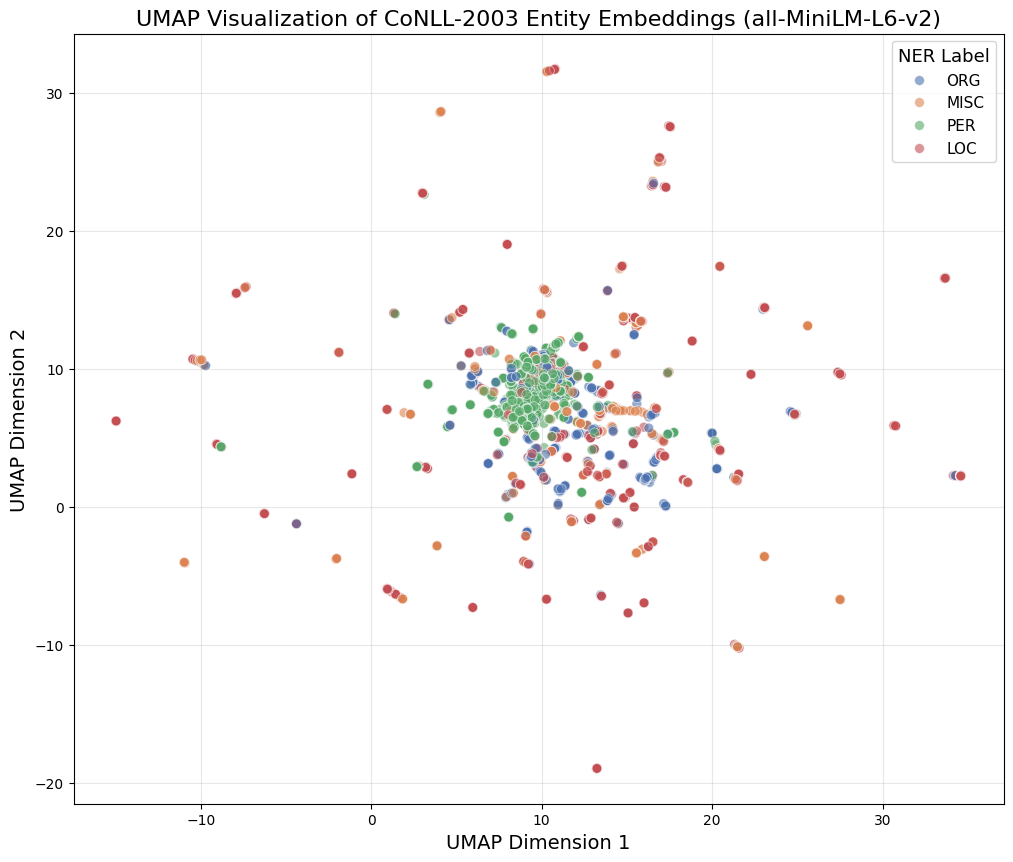

In [ ]:
print("\nGenerating scatter plot...")
plt.figure(figsize=(12, 10))

sns.scatterplot(
    x='UMAP-X', 
    y='UMAP-Y', 
    hue='Label', 
    data=df,
    legend='full',
    palette="deep", 
    alpha=0.6, 
    s=50 
)

plt.title(f'UMAP Visualization of CoNLL-2003 Entity Embeddings ({EMBEDDING_MODEL_NAME})', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(title='NER Label', title_fontsize='13', fontsize='11')

# Save the plot
UMAP_PLOT_FILENAME = "conll2003_entity_umap_plot.png"
plt.savefig(UMAP_PLOT_FILENAME, bbox_inches='tight')

print(f"\n✅ All plotting complete. UMAP plot saved to: {UMAP_PLOT_FILENAME}")